# _(Brette, et, al., 2007)_ CUBA

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

In [1]:
import numpy as np
import brainpy as bp

In [2]:
bp.backend.set('numba', dt=0.1)

In [3]:
num_exc = 3200
num_inh = 800
taum = 20
taue = 5
taui = 10
Vt = -50
Vr = -60
El = -49
we = 60 * 0.27 / 10  # excitatory synaptic weight (voltage)
wi = -20 * 4.5 / 10  # inhibitory synaptic weight
ref = 5.0

In [4]:

class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, **kwargs):
        self.V = bp.backend.ones(size) * Vr
        self.spike = bp.backend.zeros(size, dtype=bool)
        self.ge = bp.backend.zeros(size)
        self.gi = bp.backend.zeros(size)
        self.t_spike = -1e7 * bp.backend.ones(size)
        super(LIF, self).__init__(size=size, **kwargs)

    @staticmethod
    @bp.odeint
    def int_g(ge, gi, t):
        dge = - ge / taue
        dgi = - gi / taui
        return dge, dgi

    @staticmethod
    @bp.odeint
    def int_V(V, t, ge, gi):
        return (ge + gi + (El - V)) / taum

    def update(self, _t):
        self.ge, self.gi = self.int_g(self.ge, self.gi, _t)
        for i in range(self.num):
            self.spike[i] = 0.
            if (_t - self.t_spike[i]) > ref:
                V = self.int_V(self.V[i], _t, self.ge[i], self.gi[i])
                self.spike[i] = 0.
                if V >= Vt:
                    self.V[i] = Vr
                    self.spike[i] = 1.
                    self.t_spike[i] = _t
                else:
                    self.V[i] = V



In [5]:
class ExcSyn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, **kwargs):
        self.conn = conn(pre.size, post.size)
        self.pre2post = self.conn.requires('pre2post')
        super(ExcSyn, self).__init__(pre, post, **kwargs)

    def update(self):
        for pre_id in range(self.pre.num):
            if self.pre.spike[pre_id] > 0.:
                post_ids = self.pre2post[pre_id]
                for i in post_ids:
                    self.post.ge[i] += we

In [6]:
class InhSyn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, **kwargs):
        self.conn = conn(pre.size, post.size)
        self.pre2post = self.conn.requires('pre2post')
        super(InhSyn, self).__init__(pre, post, **kwargs)

    def update(self):
        for pre_id in range(self.pre.num):
            if self.pre.spike[pre_id] > 0.:
                post_ids = self.pre2post[pre_id]
                for i in post_ids:
                    self.post.gi[i] += wi

In [7]:
E_group = LIF(num_exc, monitors=['spike'])
I_group = LIF(num_inh)
E_group.V = Vr + np.random.rand(num_exc) * (Vt - Vr)
I_group.V = Vr + np.random.rand(num_inh) * (Vt - Vr)

In [8]:
E2E = ExcSyn(pre=E_group, post=E_group, conn=bp.connect.FixedProb(prob=0.02))
E2I = ExcSyn(pre=E_group, post=I_group, conn=bp.connect.FixedProb(prob=0.02))
I2E = InhSyn(pre=I_group, post=E_group, conn=bp.connect.FixedProb(prob=0.02))
I2I = InhSyn(pre=I_group, post=I_group, conn=bp.connect.FixedProb(prob=0.02))

Compilation used 3.1382 s.
Start running ...
Run 10.0% used 0.020 s.
Run 20.0% used 0.050 s.
Run 30.0% used 0.070 s.
Run 40.0% used 0.090 s.
Run 50.0% used 0.110 s.
Run 60.0% used 0.140 s.
Run 70.0% used 0.160 s.
Run 80.0% used 0.180 s.
Run 90.0% used 0.221 s.
Run 100.0% used 0.248 s.
Simulation is done in 0.248 s.



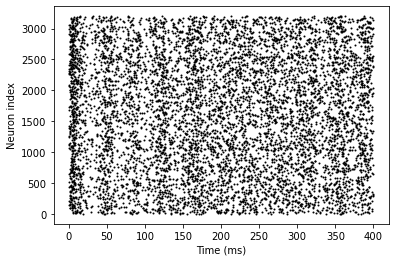

In [9]:
net = bp.Network(E_group, I_group, E2E, E2I, I2I, I2E)
net.run(400., report=True)
bp.visualize.raster_plot(net.ts, E_group.mon.spike, show=True)